### Import de Bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

### Import Dataset

In [4]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [5]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Procurando por dados nulos no Dataset

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0
var_68,0,0.0
var_67,0,0.0
var_66,0,0.0
var_65,0,0.0
var_64,0,0.0


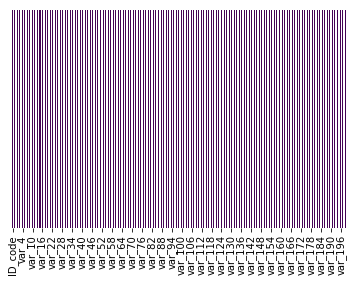

In [7]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Analisando o Y

In [8]:
df_train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

### Balanceando Dataset (Overfit)

In [9]:
df_train_0 = df_train[df_train['target']==0]
df_train_1 = df_train[df_train['target']==1]

df_train_0 = df_train_0.sample(df_train_1.shape[0], replace=True)
df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)

del df_train_0, df_train_1

In [10]:
df_train['target'].value_counts()

1    20098
0    20098
Name: target, dtype: int64

### Splitting data

In [11]:
X = df_train.drop(['target','ID_code'],axis=1)
y = df_train['target']

### Normalizando o X

In [12]:
scaler = StandardScaler()
scaler.fit(df_train.drop(['target','ID_code'],axis=1))
scaled_features = scaler.transform(df_train.drop(['target','ID_code'],axis=1))
z = df_train.drop(['target','ID_code'],axis=1)

In [13]:
df_feat = pd.DataFrame(scaled_features,columns=z.columns)
X = df_feat

In [14]:
X.describe().T.round(3).head()

,count,mean,std,min,25%,50%,75%,max
var_0,40196.0,0.0,1.0,-3.319,-0.739,-0.052,0.669,2.806
var_1,40196.0,0.0,1.0,-3.067,-0.765,0.002,0.730,2.822
var_2,40196.0,-0.0,1.0,-2.912,-0.757,-0.046,0.663,2.695
var_3,40196.0,0.0,1.0,-3.325,-0.753,0.017,0.743,2.986
var_4,40196.0,-0.0,1.0,-3.206,-0.736,0.013,0.729,3.417


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

### Identificando melhor modelo

In [16]:
classifiers = [
    KNeighborsClassifier(3),
    GaussianNB(),
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    xgb.XGBClassifier()]
    
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    y_pred = clf.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred))
    print("Recall:", metrics.recall_score(y_test, y_pred))


KNeighborsClassifier
****Results****
Accuracy: 0.5614893440583796
Precision: 0.6897410358565738
Recall: 0.22892561983471074
GaussianNB
****Results****
Accuracy: 0.8050418774359399
Precision: 0.8091258565936821
Recall: 0.8001652892561983


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
****Results****
Accuracy: 0.77552035823866
Precision: 0.7762353330028094
Recall: 0.7763636363636364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC
****Results****
Accuracy: 0.7962517621693341
Precision: 0.798968214345149
Recall: 0.7935537190082644
DecisionTreeClassifier
****Results****
Accuracy: 0.5978936893606435
Precision: 0.6012818350480689
Recall: 0.5892561983471074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
****Results****
Accuracy: 0.6412637863836139
Precision: 0.6752032520325203
Recall: 0.5490909090909091
GradientBoostingClassifier
****Results****
Accuracy: 0.7470768720457749
Precision: 0.7652050919377652
Recall: 0.7153719008264463
KNeighborsClassifier
****Results****
Accuracy: 0.5596649805124803
Precision: 0.7534246575342466
Recall: 0.18181818181818182
XGBClassifier
****Results****
Accuracy: 0.7428476656439174
Precision: 0.7611120949176554
Recall: 0.7104132231404958


### Melhor modelo escolhido Naive Bayes

In [25]:
modelo = GaussianNB()    
clf = GaussianNB()
clf.fit(X_train, y_train)
name = clf.__class__.__name__
    
print("="*30)
print(name)
    
print('****Results****')
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

GaussianNB
****Results****
Accuracy: 0.8050418774359399
Precision: 0.8091258565936821
Recall: 0.8001652892561983


In [26]:
cross_val_score(modelo, X, y, cv = 10, scoring='r2').mean()

0.22788511400191674

In [27]:
cross_val_score(modelo, X, y, cv = 10, scoring='accuracy').mean()

0.8069712785004792

In [28]:
cross_val_score(modelo, X, y, cv = 10, scoring='roc_auc').mean()

0.8876701010212937

0.8908382832226177

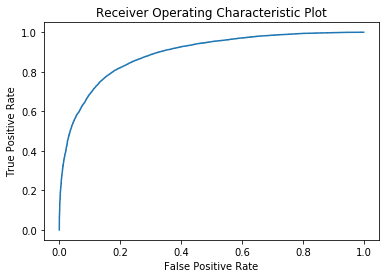

In [29]:
fpr, tpr, thr = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

### Predict test

In [30]:
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [31]:
X_test = df_test.drop(['ID_code'], axis=1)

In [32]:
for i in list(X_test):
    X_test[i] = (X_test[i] - X_test[i].mean())/ X_test[i].std()

In [33]:
X_test['target'] = clf.predict_proba(X_test)[:,1]

In [34]:
df_test['target'] = X_test['target']

In [35]:
df_test = df_test[['ID_code','target']]

In [36]:
df_test.to_csv('data/Santander_Submission.csv', index=False)